# Predicting Heart Disease
In this project, I will be working for a R&D company that focuses on providing healthcare solutions. The company has collected anonymised data from multiple hospitals on several patients. The [dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/) includes information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before. 

I will be using the dataset to accurately predict the likelihood of a new patient having heart disease in the future. 

## Exploratory Data Analysis
Before beginning exploratory analysis, these are the key abbreviations and definitions that are used in the dataset:
* `ChestPainType` - TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic
* `FastingBS` - Fasting blood sugar (1: if FastingBS > 120 mg/dl, 0: otherwise)
* `RestingECG` - ST: Having ST-T wave abnormality, LVH: Showing probable or definite left ventricular hypertrophy by Estes' criteria
* `ST_Slope` - The slope of the peak exercise ST segment (Up: upsloping, Flat: flat, Down: downsloping)

In [1]:
# Import data handling module
import pandas as pd

# Load dataset
heart = pd.read_csv('Datasets/heart.csv')

In [2]:
# Explore dataset structure
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
# Output number of rows and columns
heart.shape

(918, 12)

### Descriptive Statistics
I will first explore and analyse the numerical columns:
* `Age` - Age of the patient (years)
* `RestingBP` - Resting blood pressure (mm Hg)
* `Cholesterol` - Serum cholesterol (mm/dl)
* `MaxHR` - Maximum heart rate achieved (between 60 and 202)
* `Oldpeak` - oldpeak = ST (Numeric value measured in depression)

In [4]:
# Display summary statistics for aformentioned features
heart.drop(columns=['FastingBS', 'HeartDisease']).describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


Upon reviewing the summary statistics for the numerical features, one issue that can be spotted is the minimum value of 0 for the `RestingBP` feature. This suggests that there is no blood being pumped around the body of the given person representing that observation which is physiologically impossible. Further investigation into this column is therefore necessary. This is also true for the minimum value of 0 for the `Cholesterol` feature, an unusual reading. 603 mm/dl is a very high serum cholesterol reading however not implausible. Finally, the `Oldpeak` feature contains a negative value, evident by its minimum value of -2.6. Negative values should not be present in this feature and may be a result of incorrect data entry or interpretation. 

### Visualisations
I will now be creating visualisations to understand how the data is distributed amongst the categorical features.

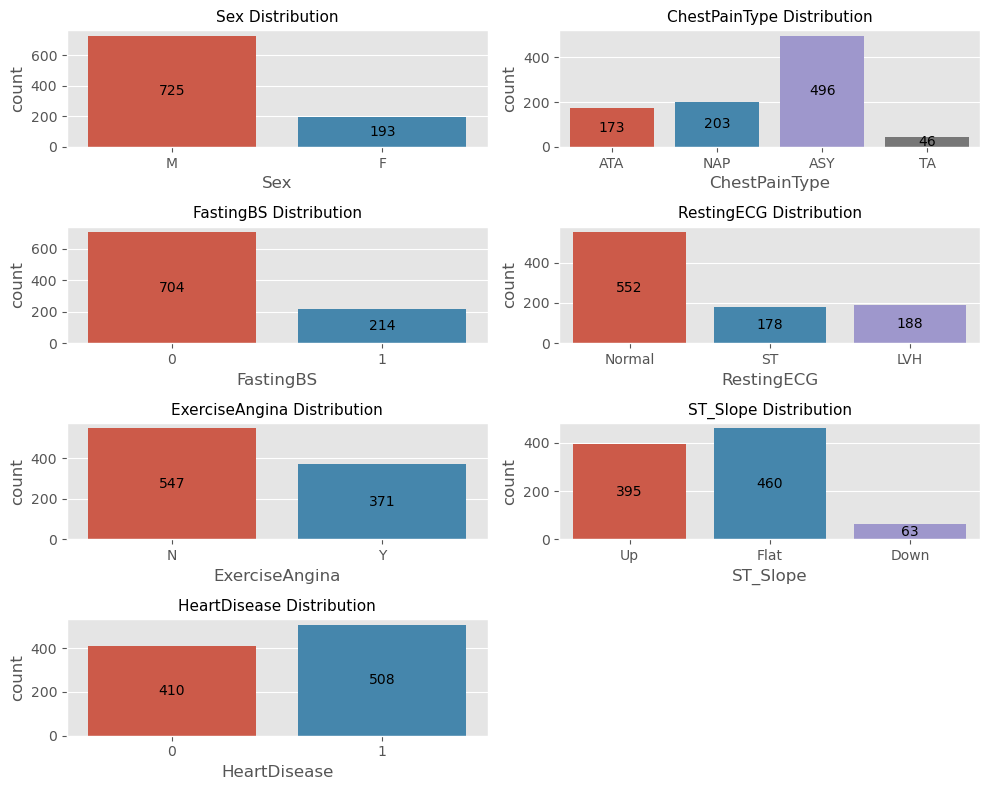

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# List categorical features
categorical = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']

fig = plt.figure(figsize=(10,8))
plt.style.use('ggplot')

# Generate plots for each categorical feature
for i, cat in enumerate(categorical):
    # Generate bar plot of counts
    ax = plt.subplot(4,2,i+1)
    sns.countplot(x = heart[cat], ax = ax)
    # Set title
    ax.set_title(f'{cat} Distribution', fontsize=11)
    
    # Annotate the bars with counts
    for container in ax.containers:
        ax.bar_label(container, label_type="center")    

plt.tight_layout()
plt.show()

From viewing the visualisations, there is a much greater proportion of patients that are male (725:193). Furthermore, we see more patients (55%) suffering from heart disease. Now I will have a look at the frequencies of each categorical feature after grouping the values by the `HeartDisease` feature.

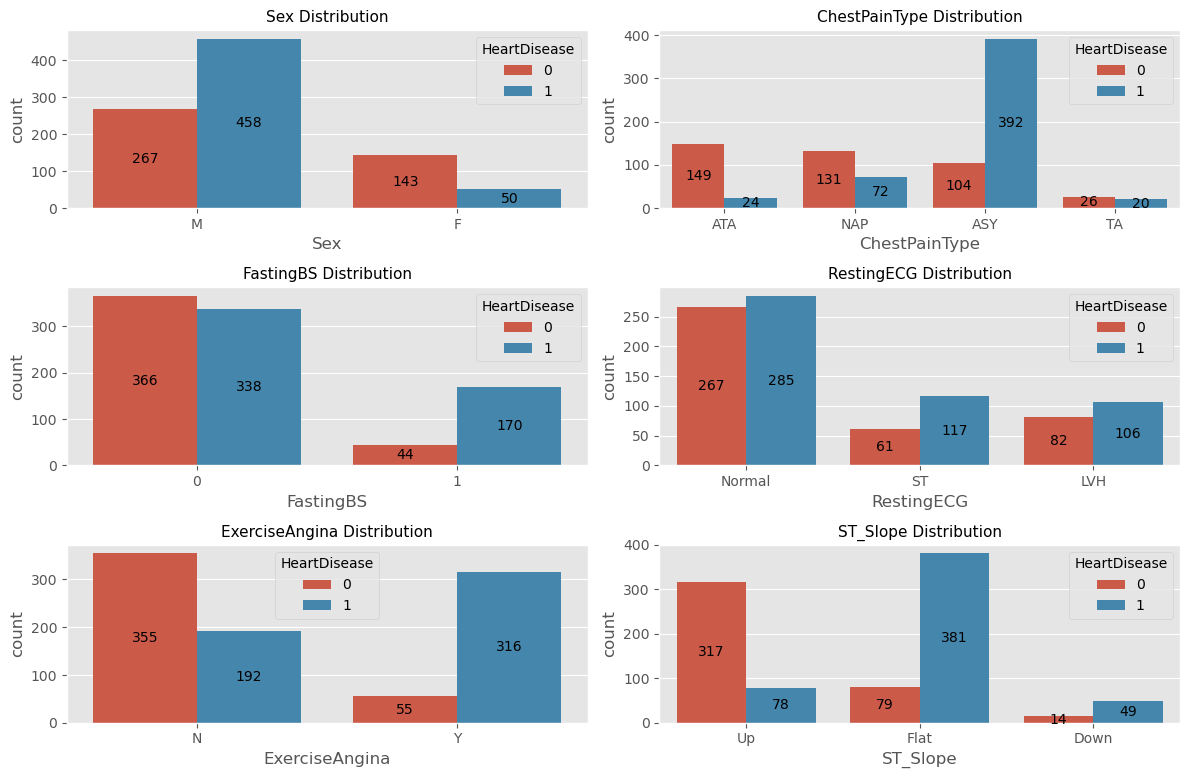

In [6]:
fig = plt.figure(figsize=(12,10))

# Generate plots for each categorical feature
for i, cat in enumerate(categorical):
    # Avoid HeartDisease plot generation
    if cat == 'HeartDisease':
        continue
    # Generate bar plot of counts
    ax = plt.subplot(4,2,i+1)
    sns.countplot(x = heart[cat], hue = heart['HeartDisease'], ax = ax)
    # Set title
    ax.set_title(f'{cat} Distribution', fontsize=11)
    
    # Annotate bars with count values
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

plt.tight_layout()
plt.show()

After grouping by `HeartDisease`, some key insights can be taken away:
* Significantly more males have heart disease in this dataset whereas heart disease in females is the lesser occurrence. This could potentially induce a bias in a machine learning model and impact predictions for any female patients in any unseen data.
* In comparison to other chest pain types, heart disease in asymptomatic patients is significantly more prevalent, with suffering from heart disease being the common occurrence. In contrast, for all other forms of chest pain, suffering from heart disease is less frequent. While chest pain could be a relevant feature for a model, it should be noted that asymptomatic implies that those patients who had heart disease did not have chest pain as a symptom.
* Heart disease is more prevalent in patients with a fasting blood sugar greater than 120 mg/dl.
* Heart disease is more prevelent in patients with exercise-induced angina.
* Heart disease is significantly more prevalent in patients with flat peak exercise ST segment, as well as it also being slightly more prevalent in patients with a downsloping peak exercise ST segment. In contrast, we see that in patients with an upsloping peak exercise ST segment, not suffering from heart disease is the more common occurrence.
* 410 patients have not been diagnosed with heart disease, whereas 508 patients have been. This shows that the target variable is somewhat evenly distributed, which is beneficial for training a model.

## Data Cleaning
Previously, when reviewing the summary statistics for the numerical features in the dataset, I identified two columns that have 0 values present that seemed illogical. To understand the best way to deal with these rows, I will first identify how many of these rows are present.

In [7]:
heart[heart['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [8]:
heart[heart['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


It can be seen that only 1 patient had a registered resting blood pressure of 0. Considering they also have a value of 0 for `Cholesterol`, it is likely that data was incorrectly inputted for this individual. As only they are affected in such a manner, they will be removed from the dataset.

In [9]:
# Remove patient 449
heart = heart[heart['RestingBP'] > 0]

In [10]:
heart.shape

(917, 12)

There are 171 patients (excluding the removed patient) that have a registered cholesterol reading of 0. In a dataset containing 917 observations, removing 171 of those observations is a drastic measure, as that represents removal of ~19% of the dataset. Instead, these values will be replaced with the median value of `Cholesterol` respective to their corresponding categorical features (`Sex`, `ChestPainType`, `FastingBS`, `RestingECG`, `ExerciseAngina`, `ST_Slope`, `HeartDisease`).

In [11]:
# Establish dataset with logical cholesterol vals
heart_chol = heart[heart['Cholesterol'] > 0]
heart_chol

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [12]:
# Define function for median calcs
def group_chol(row):
    if row['Cholesterol'] > 0:
        return row['Cholesterol']
    
    # Access patient data
    sex = row['Sex']
    chest = row['ChestPainType']
    fast = row['FastingBS']
    rest = row['RestingECG']
    ex = row['ExerciseAngina']
    st = row['ST_Slope']
    hd = row['HeartDisease']
    
    # Find matching patient data
    matching = heart_chol[(heart_chol['Sex'] == sex) & (heart_chol['ChestPainType'] == chest) &
                          (heart_chol['FastingBS'] == fast) & (heart_chol['RestingECG'] == rest) &
                          (heart_chol['ExerciseAngina'] == ex) &(heart_chol['ST_Slope'] == st) &
                          (heart_chol['HeartDisease'] == hd)]
    
    # Find median Cholesterol for group
    med_chol = matching['Cholesterol'].median()
    
    return med_chol

In [13]:
# Apply func. to cholesterol feature
heart['Cholesterol'] = heart.apply(group_chol, axis=1)

In [14]:
# Check for remaining 0s in cholesterol
heart[heart['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


## Feature Selection
Now that the data is cleaned, I can begin focusing on building a model.

I'll begin by converting the categorical features into dummy variables.

In [15]:
# Create dummy variables
heart = pd.get_dummies(data = heart, drop_first = True)

I can now create a Pearson's correlation heat map to identify which features are reasonably correlated to `HeartDisease`.

<Axes: >

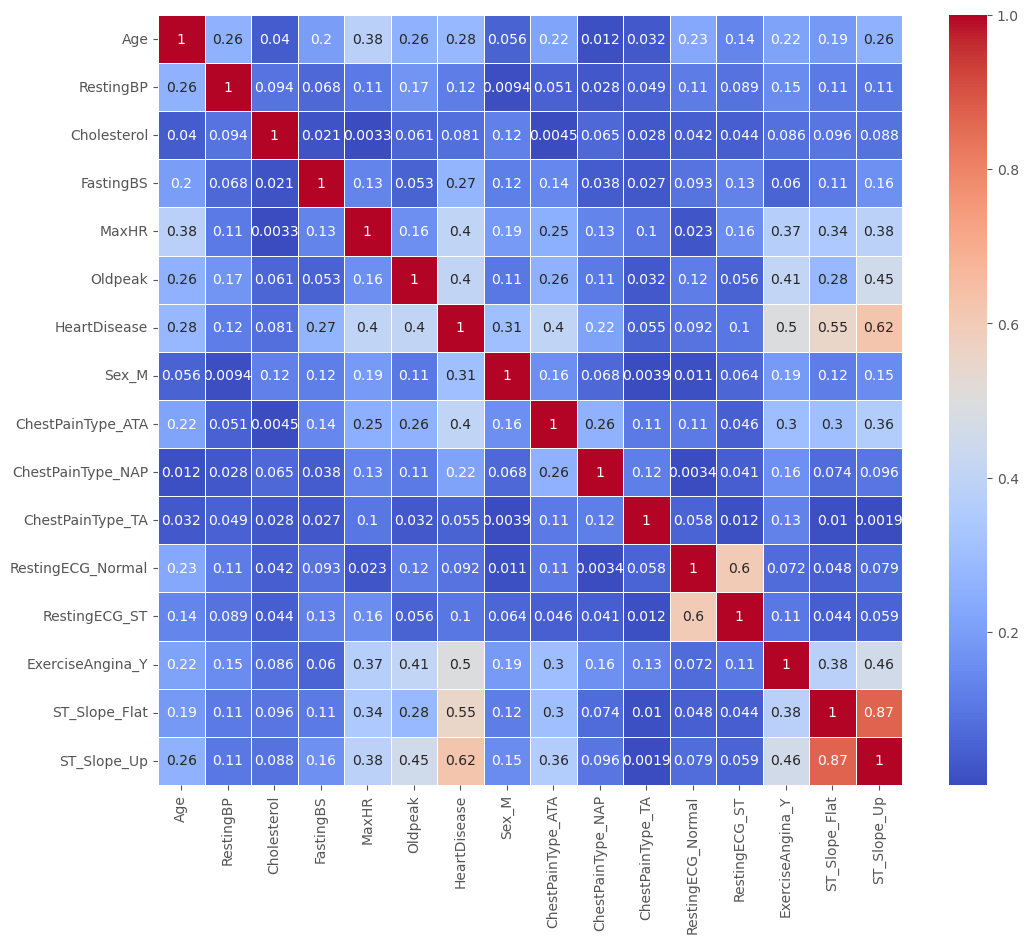

In [16]:
# Calculate correlations
correlations = abs(heart.corr())
# Generate correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(correlations, annot=True, linewidths=.5, cmap = 'coolwarm')

As moderate correlations have absolute values of 0.3 or greater, To identify features reasonaly correlated with `HeartDisease`, I will use a cutoff point of abs(0.3).

<Axes: >

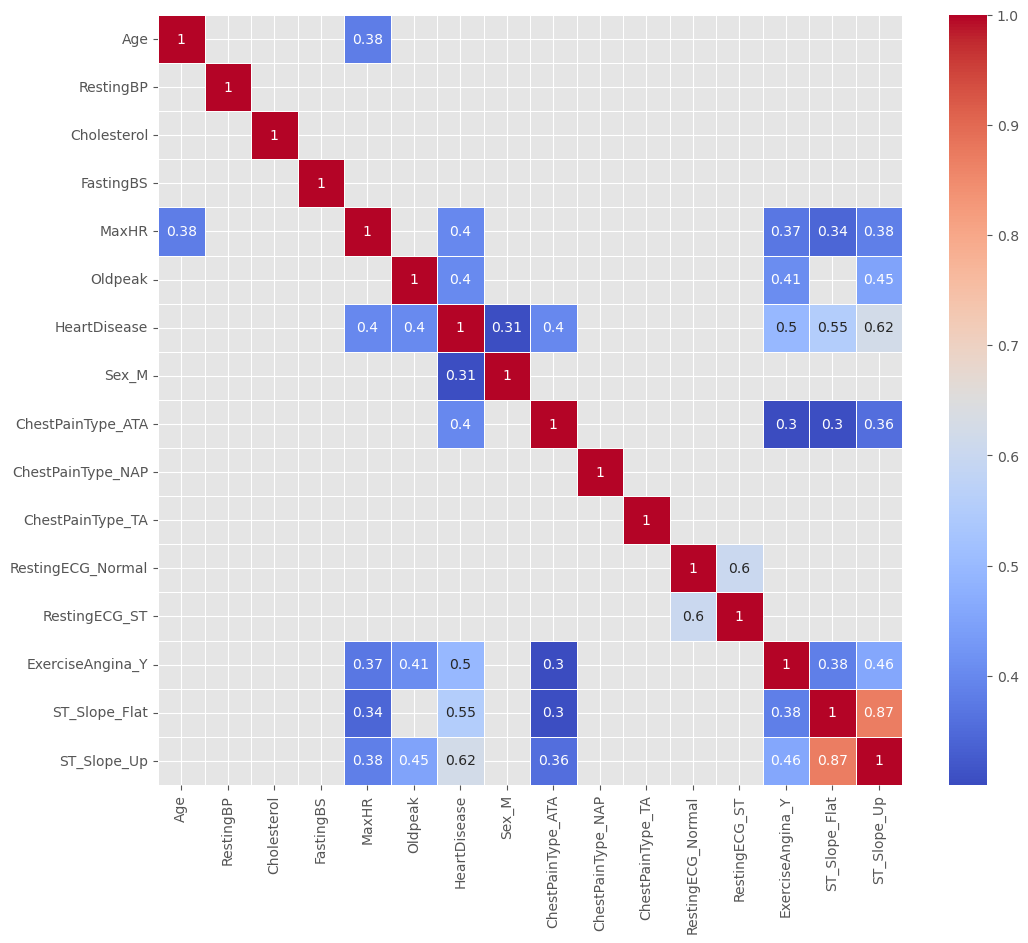

In [17]:
# Generate correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(correlations[correlations > 0.3], annot=True, linewidths=.5, cmap = 'coolwarm')

From the correlation heatmap, the following features can be identified as being reasonably correlated with `HeartDisease`:
* `MaxHR`
* `Oldpeak`
* `Sex_M`
* `ChestPainType_ATA`
* `ExerciseAngina_Y`
* `ST_Slope_Flat`
* `ST_Slope_Up`

These will be the features first used to build a model to predict heart disease in a patient.

## Building a Classifier
To begin, I will create and train multiple models using one of the aforementioned features at a time.

In [45]:
# Import necessary ML modules
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

# Select features
features = ['MaxHR', 'Oldpeak', 'Sex_M', 'ChestPainType_ATA', 'ExerciseAngina_Y',
            'ST_Slope_Flat', 'ST_Slope_Up']

# Set features and target variables
X = heart[features]
y = heart['HeartDisease']

# Split data into training, validation and test data - 60:20:20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 309)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.25, random_state = 309)

# Build model for each feature
for f in features:
    knn = KNeighborsClassifier(n_neighbors = 18)
    knn.fit(X_train[[f]], y_train)
    accuracy = knn.score(X_val[[f]], y_val)
    print(f'{f} Model Accuracy: {accuracy}')

MaxHR Model Accuracy: 0.6956521739130435
Oldpeak Model Accuracy: 0.6902173913043478
Sex_M Model Accuracy: 0.6739130434782609
ChestPainType_ATA Model Accuracy: 0.7065217391304348
ExerciseAngina_Y Model Accuracy: 0.7608695652173914
ST_Slope_Flat Model Accuracy: 0.8206521739130435
ST_Slope_Up Model Accuracy: 0.842391304347826


When training the model on one feature, training the model on `ST_Slope_Up` provided the most accurate model - 84.2%. A very close second is the `ST_Slope_Flat` model, at 82.1%, showing that the `ST_Slope` is likely a key feature in identifying heart disease in a patient. `ExerciseAngina_Y` also appears to be a strong feature in isolation for training a model, at 76.1%.

I will now train a model using all of the selected features.

In [46]:
# Set scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

knn = KNeighborsClassifier(n_neighbors = 18)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print(f'Model accuracy: {accuracy}')

Model accuracy: 0.8913043478260869


Using all features combined resulted in the best performing model yet, with 89.1% accuracy - increasing by 4.9%.

## Hyperparameter Tuning
Now that I have a reasonably well-performing model, I can experiment with the hyperparameters.

In [50]:
# Import GridSearchCV - searches over specified parameters
from sklearn.model_selection import GridSearchCV

# Split dataset into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 309)

# Scale training set
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Set hyperparameters to test
params = {'n_neighbors': range(1,20),
         'weights': ['uniform', 'distance'],
         'p': [1,2],
         'algorithm': ['ball_tree', 'kd_tree', 'brute']}

# Establish model hyperparameter tuning
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, params, scoring = 'accuracy')
grid_search.fit(X_train_scaled, y_train)

# Access grid search attributes
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Output results
print(f'The best model was {best_model}, with an accuracy of {best_score * 100:.1f}%.\nThis was achieved using the following parameters: {best_params}.')

The best model was KNeighborsClassifier(algorithm='ball_tree', n_neighbors=17), with an accuracy of 83.36%.
This was achieved using the following parameters: {'algorithm': 'ball_tree', 'n_neighbors': 17, 'p': 2, 'weights': 'uniform'}


Using the `GridSearchCV` approach, a decrease in model performance is observed - dropping from 89.1% to 83.4%. Although the model dropped in accuracy, this accuracy score is more likely to be a better estimate of how the model would perform as it uses cross-validation.

## Model Evaluation on Test Set
I'll now evaluate this model on the test set using the model above.

In [57]:
# Scale test set
X_test_scaled = scaler.transform(X_test)

# Calculate  model accuracy
accuracy = best_model.score(X_test_scaled, y_test)
print(f'The model has an accuracy of: {accuracy*100:.2f}%')

The model has an accuracy of: 88.04%


The model performs well, with an accuracy of 88%. This means the model can correctly predict the risk of a patient having heart disease 88% of the time. 

However, it is important to note that the model performs better on the test set than the training set, which may be a cause of concern. A likely reason for this may be due to the distribution of the data. When performing the exploratory data analysis, it was observered that there were significantly more males than females that had heart disease. This could introduce a bias as the model may believe that being a male holds significantly more weighting towards the risk of heart disease than may actually be the case. Let's have a look at the distribution of males and females in the data.

In [66]:
# Observe sex distribution amongst datasets
print(f"Males in X dataset: {X['Sex_M'].sum()}\nFemales in X dataset: {X['Sex_M'].size - X['Sex_M'].sum()}\n")
print(f"Males in X_train dataset: {X_train['Sex_M'].sum()}\nFemales in X_train dataset: {X_train['Sex_M'].size - X_train['Sex_M'].sum()}\n")
print(f"Males in X_test dataset: {X_test['Sex_M'].sum()}\nFemales in X_test dataset: {X_test['Sex_M'].size - X_test['Sex_M'].sum()}")

Males in X dataset: 724
Females in X dataset: 193

Males in X_train dataset: 580
Females in X_train dataset: 153

Males in X_test dataset: 144
Females in X_test dataset: 40


As the distributions show, there are significantly more males in all three datasets meaning the model was trained on more male data than female data, introducing a sex bias. Since the test dataset only had 40 female patients, having a higher model accuracy on the test set compared to the training set can be understood. However, other factors may also be contributing to this increase in model performance for the test set.

## Conclusion
The final model used the following features:
* `MaxHR`
* `Oldpeak`
* `Sex_M`
* `ChestPainType_ATA`
* `ExerciseAngina_Y`
* `ST_Slope_Flat`
* `ST_Slope_Up`

After performing hyperparameter tuning, using the features in the model resulted in an accuracy of 88% on the test set, seeming to be a well-performing model. However, data limitations may result in this accuracy not being as indicative of a well-performing model as it appears to be. To overcome this obstacle, some things that could be done include:
* Experimenting with different combinations of features (removal of the `Sex_M` feature)
* Experiment with other machine learning algorithms
* Collecting more data, ensuring it is proportional to population (stratified sampling could be used)